### Imports


In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

import sys  # update paths
import os  # import os in order to find relative path
import glob
import numpy as np 
import matplotlib.pyplot as plt
import re
import h5py

from collections import Counter

#rt = '/Users/sph/Library/CloudStorage/GoogleDrive-sphar01@stanford.edu/Shared Drives/SLab/'
rt = 'G:/Shared Drives/SLab/'
sys.path.append(rt + 'Shannon/Code/meas_analysis')
sys.path.append(rt + 'Shannon/Code/scresonators')
#sys.path.append('/Users/sph/Library/CloudStorage/GoogleDrive-spharvey3@gmail.com/My Drive/Schuster/Code/Git')

from slab.datamanagement import SlabFile
import handy as hy 

import fit_resonator.resonator as scres
import time 
import seaborn as sns
import scipy.constants as cs
from scipy.optimize import curve_fit

min_power = -78
atten = -50 
#import importlib 
#importlib.reload(scres)

Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver


In [20]:
pth_base = rt + 'JJ_fab/Coherence Sample/Resonators Measurement/240725/data/'

folder_path = pth_base  # Replace with the actual folder path

directories = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
directories = sorted(directories)
dir_base = directories[2]

directories = directories[3:-1]

### Grab list of resonators and files

In [15]:
def get_resonators(folder, pattern):
    
    # List of files
    pth = pth_base + folder
    file_list0 = os.listdir(pth)
    print(len(file_list0))

    tokens=[]
    # Get a list of resonators 
    for i in range(len(file_list0)):
        tokens.append(re.findall(pattern, file_list0[i]))

    values = [int(token) for sublist in tokens for token in sublist]
    resonators = set(values)

    frequency = Counter(values)
    print(frequency)

    resonators = np.array(list(resonators))
    resonators.sort()
    return resonators, file_list0

### Fit resonator func

In [16]:
def fit_resonator(data, filename, output_path, fit_type='DCM'):
    # fit type DCM, CPZM
    my_resonator = scres.Resonator()
    my_resonator.outputpath = output_path 
    my_resonator.filename = filename
    my_resonator.from_columns(data['freqs'], data['amps'], data['phases'])
    # Set fit parameters

    MC_iteration = 4
    MC_rounds = 1e3
    MC_fix = []
    manual_init = None
    my_resonator.preprocess_method = 'linear' # Preprocess method: default = linear
    my_resonator.filepath = './' # Path to fit output
    #my_resonator.plot=None # 'png'
    # Perform a fit on the data with given parameters
    my_resonator.fit_method(fit_type, MC_iteration, MC_rounds=MC_rounds, MC_fix=MC_fix,manual_init=manual_init, MC_step_const=0.3)
    output = my_resonator.fit(None)
    return output 

# conf_array = [Q_conf, Qi_conf, Qc_conf, Qc_Re_conf, phi_conf, w1_conf]
# Q, Qc, Frequency, Phase 

### Load directory list

In [17]:
#data = {'freqs':xdata*1e6, 'amps':20*np.log10(amp), 'phases':-phs_correct} 
# qi_phi_list is the one you get from rotation 
res_data=[]
# Make format of temp x resonators x power 
# This assumes we have the same resonators at each temperature.
# each dictionary is for a different resoantors 

temps = np.array([float(d[7:]) for d in directories])
print(temps)
max_temp = 1500
inds = np.where(temps < max_temp)
temps = temps[inds]
directories = np.array(directories)[inds]
inds = np.argsort(temps)
temps = temps[inds]
directories = directories[inds]
print(directories)

ValueError: could not convert string to float: 'weep2'

### Loop for processing R+S data for temp and power and res sweep

Each folder is a given temp, combines resonators and powers. 

In [25]:

def analyze_sweep(directories):
    pattern0 = r'res_(\d+)_\d{2}dbm'

    resonators, file_list = get_resonators(directories[0], pattern0)
    res_params = [None] * len(resonators)
    for i in range(len(resonators)):
        res_params[i] = {'freqs':[], 'phs':[], 'q':[], 'qi':[], 'qc':[], 'qi_phi':[], 'pow':[]}

    for i in range(len(directories)):
        start = time.time()
        print(i)
        output_path = './procdata_' + directories[i] + '/'
        resonators, file_list0 = get_resonators(directories[i], pattern0)
        pth = pth_base + directories[i]
        for j in range(len(resonators)):
            # Grab all the files for a given resonator, then sort by power. 
            pattern = 'res_{:d}_'.format(resonators[j]) + '\d{2}dbm'
            file_list = [file for file in file_list0 if re.search(pattern, file)]
            file_list.sort()
            file_list = file_list[::-1]
            print(file_list)
            params, err, power = [], [], []
            for k in range(len(file_list)):
                data, attrs = hy.prev_data(pth, file_list[k])

                # Reformat data for scres package
                data['phases'] = np.unwrap(data['phases'][0])
                data['freqs']=data['fpts'][0]
                data['amps']=data['mags'][0]

                # Skip really noisy ones since they are slow

                pow_curr = data['vna_power'][0]            
                if pow_curr < min_power: 
                    continue
                power.append(data['vna_power'][0])
                try:
                    output = fit_resonator(data, file_list[k], output_path, 'DCM')    
                    params.append(output[0])
                    err.append(output[1])
                except: 
                    print('fit failed')
                    params.append([np.nan,np.nan,np.nan,np.nan])
                    err.append([np.nan,np.nan,np.nan,np.nan, np.nan, np.nan])

            # Put all the data for a given resonator/temp in arrays. 
            power=np.array(power)
            res_params[j]['pow'].append(power)
            
            q = np.array([params[k][0] for k in range(len(params))])
            qc = np.array([params[k][1] for k in range(len(params))])
            freq = np.array([params[k][2] for k in range(len(params))])
            phase = np.array([params[k][3] for k in range(len(params))])
            qi_phi = 1/(1/q-1/qc)
            Qc_comp = qc / np.exp(1j * phase)
            Qi = (q ** -1 - np.real(Qc_comp ** -1)) ** -1

            res_params[j]['q'].append(q)
            res_params[j]['qc'].append(qc)
            res_params[j]['freqs'].append(freq)
            res_params[j]['phs'].append(phase)
            res_params[j]['qi_phi'].append(qi_phi)
            res_params[j]['qi'].append(Qi)
            
            end = time.time()
            print('Time elapsed: ', end-start)
            inds = power >= -70
            fig, ax = plt.subplots(2,1, figsize=(6,5), sharex=True)
            ax[0].plot(power[inds], Qi[inds], '.', markersize=6)
            ax[0].set_ylabel('$Q_i$')
            ax[1].plot(power[inds], qc[inds], '.', markersize=6)
            ax[1].set_ylabel('$Q_c$')
            ax[1].set_xlabel('Power (dBm)')
            fig.suptitle('$f_0 = $ {:3.3f} GHz'.format(freq[0]/1e9))
            fig.tight_layout()
            plt.savefig('/Users/sph/' + 'resonator_power_'+str(directories[i]) + str(resonators[j]) + '.png', dpi=300)

    for i in range(len(resonators)):
        for key in res_params[i].keys():
            res_params[i][key] = np.array(res_params[i][key])

    return res_params

8
Counter({5825970: 6})
0
8
Counter({5825970: 6})
['res_5825970_25dbm', 'res_5825970_22dbm', 'res_5825970_19dbm', 'res_5825970_16dbm', 'res_5825970_13dbm', 'res_5825970_10dbm']
Time elapsed:  1.6564409732818604


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Users\\sph\\resonator_power_power_sweep15825970.png'

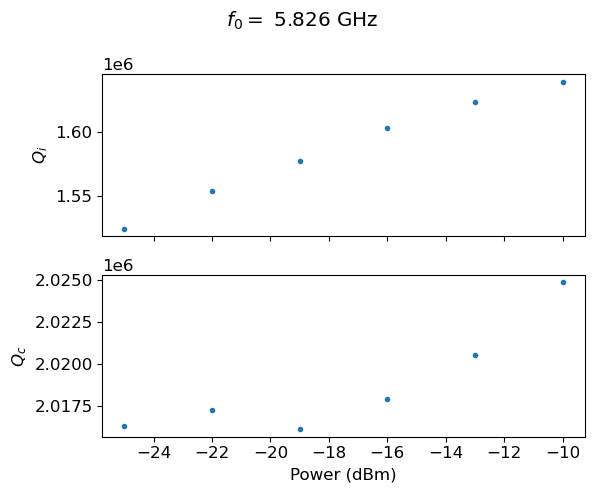

In [26]:
res_params0 = analyze_sweep([dir_base])

10
Counter({5825970: 8})
0
10
Counter({5825970: 8})
['res_5825970_31dbm', 'res_5825970_28dbm', 'res_5825970_25dbm', 'res_5825970_22dbm', 'res_5825970_19dbm', 'res_5825970_16dbm', 'res_5825970_13dbm', 'res_5825970_10dbm']
Time elapsed:  2.2144904136657715


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Users\\sph\\resonator_power_power_sweep25825970.png'

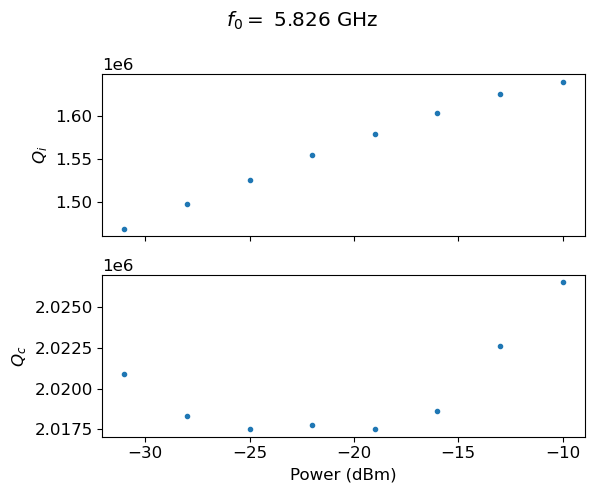

In [27]:
res_params=analyze_sweep(directories)

### Plot qualities vs temp and power

In [28]:
i=5
xval = 'temp' 
plt.rcParams['lines.markersize'] = 4
plt.rcParams['lines.linewidth'] = 1

inds = np.argsort(temps)
en = 1e-3*temps[inds]*cs.k/cs.h/res_params[i]['freqs'][inds,0]
if xval == 'temp': 
    x = temps[inds]
    xlab = 'Temperature (mK)'
else:     
    x=en
    xlab = '$k_B T / h f_0$'

min_freq = np.nanmin(res_params[i]['freqs'][inds,:])
sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[1])

# Temperature sweep 
fig, ax = plt.subplots(4,1, figsize=(6,9), sharex=True) 
for j in range(res_params[i]['pow'].shape[1]):
    ax[0].plot(x, res_params[i]['qi'][inds,j], '.-')
    #ax[1].plot(temps[inds], res_params[i]['qi'][inds,j]/res_params[i]['qi'][inds,j][0], '.-')
    ax[1].plot(x, res_params[i]['qi'][inds,j]/np.max(res_params[i]['qi'][inds,j]), '.-')
    ax[2].plot(x, res_params[i]['qc'][inds,j], '.-')
    ax[3].plot(x, (res_params[i]['freqs'][inds,j]-min_freq)/min_freq, '.-')


# norm = plt.Normalize(np.min(temps), np.max(temps))
# sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
# ax[1].figure.colorbar(sm, ax=ax[1])

#norm = plt.Normalize(np.min(res_params[i]['pow']), np.max(res_params[i]['pow']))
#sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
#ax[0].figure.colorbar(sm, ax=ax[0])

ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_i(0)$')
ax[2].set_ylabel('$Q_c$')
ax[3].set_xlabel('Temperature (mK)')
ax[3].set_xlabel(xlab)
ax[3].set_ylabel('$\Delta f/f_0$')

fig.tight_layout()
sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[0]+1)

fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 
#sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[0]-2)


ax[0].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0], '.-', label='60') #str(temps[j])+ ' mK'
ax[1].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0]/np.max(res_params0[i]['qi'][0]), '.-', label='60') #str(temps[j])+ ' mK'

for j in inds:
    ax[0].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:], '.-', label=int(temps[j])) #str(temps[j])+ ' mK'    
    ax[1].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:]/np.max(res_params[i]['qi'][j,:]), '.-')
    #ax[1].plot(res_params[i]['pow'][0,:], res_params[i]['qi'][j,:]/res_params[i]['qi'][j,:][0], '.-')


ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_i(0)$')
ax[1].set_xlabel('Power (dBm)')

ax[0].legend(fontsize=8)
fig.tight_layout()

NameError: name 'temps' is not defined

In [29]:
colors = ['#4053d3', '#b51d14', '#ddb310','#00b25d','#00beff', '#fb49b0', '#cacaca']
colors = ['#4053d3', '#b51d14', '#ddb310','#00b25d','#00beff', '#c94cbe', '#cacaca']
colors = ['#4053d3', '#b51d14', '#ddb310','#00b25d','#7bc8f6', '#ce5dae', '#cacaca']
colors = ['#4053d3', '#b51d14', '#ddb310','#02ab2e','#06b1c4', '#ce5dae', '#cacaca']
#0e87cc

sns.set_palette(colors)
xval = 'temp' 
plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.linewidth'] = 1.5
inds = np.argsort(temps)
en = 1e-3*temps[inds]*cs.k/cs.h/res_params[i]['freqs'][inds,0]
if xval == 'temp': 
    x = temps[inds]
    xlab = 'Temperature (mK)'
else:     
    x=en
    xlab = '$k_B T / h f_0$'

res_params[i]['qi'][inds,j]/np.max(res_params[i]['qi'][inds,j])

j=0
# Temperature sweep 
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 



for i in range(len(res_params)):
    inds2 = res_params[i]['qi'][inds,j]/np.max(res_params[i]['qi'][inds,j]) > 0.72
    min_freq = np.nanmin(res_params[i]['freqs'][inds,:])
    x = temps[inds2]

    ax[0].plot(x, res_params[i]['qi'][inds2,j]/np.max(res_params[i]['qi'][inds2,j]), '.-')
    ax[1].plot(x, (res_params[i]['freqs'][inds2,j]-min_freq)/min_freq, '.-')

ax[0].set_ylabel('$Q_i/Q_{i,max}$')
ax[1].set_xlabel(xlab)
ax[1].set_ylabel('$\Delta f/f_0$')
plt.savefig('/Users/sph/' + 'temp_sweep.png', dpi=300)

NameError: name 'temps' is not defined

In [30]:
temps

NameError: name 'temps' is not defined

In [31]:
inds = res_params[i]['qi'][:,j]/np.max(res_params[i]['qi'][inds,j]) > 0.7


NameError: name 'res_params' is not defined

NameError: name 'res_params0' is not defined

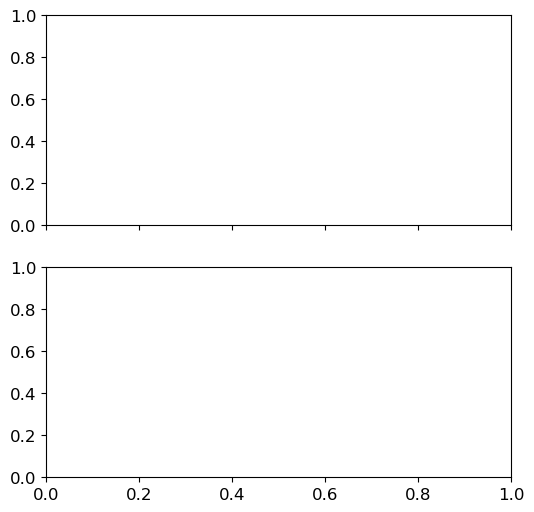

In [32]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02']
colors = ['#4053d3', '#b51d14', '#ddb310','#00b25d','#00beff', '#fb49b0', '#cacaca']
sns.set_palette(colors)
#sns.set_palette('husl', n_colors=6)
fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 
#sns.set_palette('coolwarm', n_colors=res_params[0]['pow'].shape[0]-2)

plt.rcParams['lines.markersize'] = 4

for i in range(len(res_params0)):
    ax[0].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0], '.-', label=round(np.min(res_params0[i]['freqs']/1e9),4)) #str(temps[j])+ ' mK'
    ax[1].plot(res_params0[i]['pow'][0], res_params0[i]['qi'][0]/np.max(res_params0[i]['qi'][0]), '.-', label='60') #str(temps[j])+ ' mK'
    ax[0].legend()

ax[1].set_xlabel('Power')
ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_{i,max}$')
ax[0].set_title('60 mK')
fig.tight_layout()
fig.savefig('/Users/sph/' + 'Qi_pow.png', dpi=300)

fig, ax = plt.subplots(2,1, figsize=(6,6), sharex=True) 

j=0
for i in range(len(res_params)):
    ax[0].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:], '.-', label=round(np.min(res_params[i]['freqs']/1e9),4)) #str(temps[j])+ ' mK'    
    ax[1].plot(res_params[i]['pow'][j,:], res_params[i]['qi'][j,:]/np.max(res_params[i]['qi'][j,:]), '.-')

ax[0].legend()
ax[1].set_xlabel('Power')
ax[0].set_ylabel('$Q_i$')
ax[1].set_ylabel('$Q_i/Q_{i,max}$')
ax[0].set_title('120 mK')
fig.tight_layout()

fig.savefig('/Users/sph/' + 'Qi_pow2.png', dpi=300)

fig, ax = plt.subplots(1,1, figsize=(5,4))
freqs = np.array([np.min(res_params[i]['freqs'])/1e9 for i in range(len(res_params))])
qc = np.array([np.min(res_params[i]['qc']) for i in range(len(res_params))])

ax.plot(freqs, qc, '.', markersize=10)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('$Q_c$')
fig.tight_layout()

fig.savefig('/Users/sph/' + 'Qc_vs_freq.png', dpi=300)

### Plot corrected data 

NameError: name 'resonators' is not defined

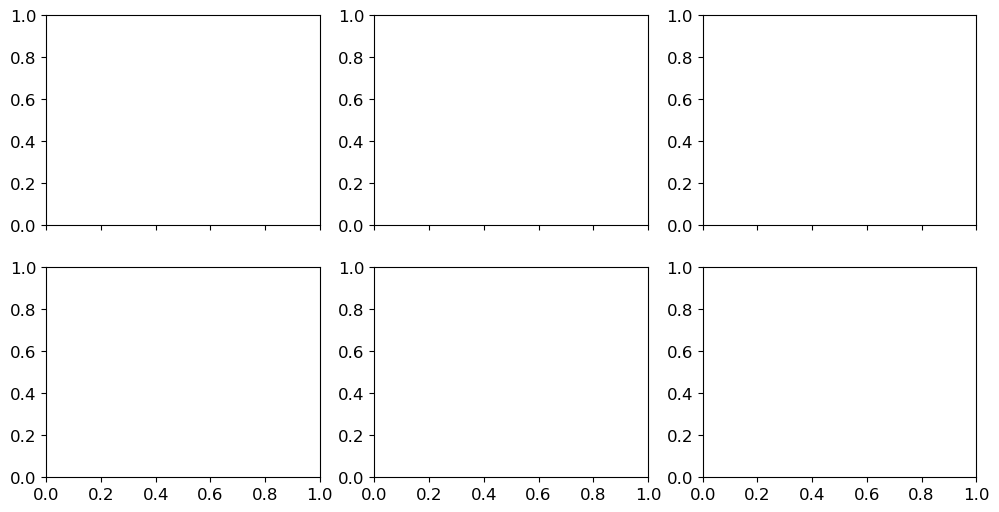

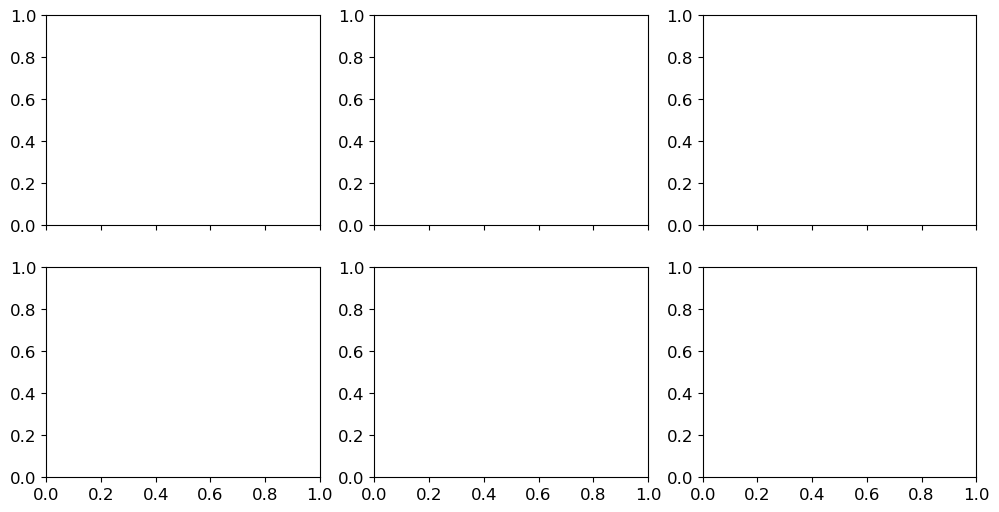

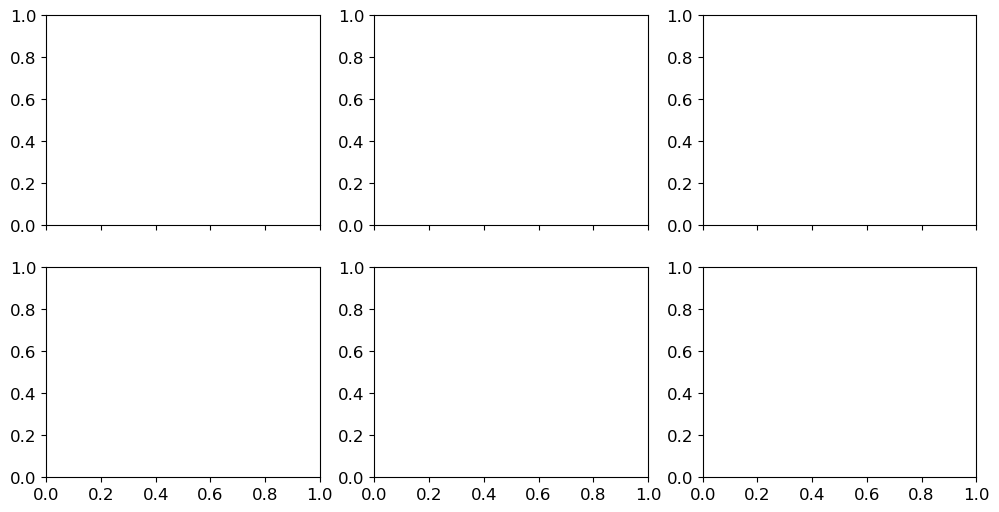

In [33]:
fig, ax = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax = ax.flatten()

fig2, ax2 = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax2 = ax2.flatten()

fig3, ax3 = plt.subplots(2,3, figsize=(12,6), sharex=True)
ax3 = ax3.flatten()

for i in range(len(resonators)):
    inds=pow_list[i]>-70
    ax[i].plot(pow_list[i][inds], qi_list[i][inds], 'o', markersize=4)
    ax[i].plot(pow_list[i][inds], qi_phi_list[i][inds], 'o', markersize=4)
    ax2[i].plot(pow_list[i][inds], phs_list[i][inds], 'o', markersize=4)
    ax[i].set_title('Resonator {:d}'.format(resonators[i]))
    #ax[i].set_xlabel('Power (dBm)')
    ax[i].set_ylabel('$Q_i$')
    ax3[i].plot(pow_list[i][inds], qc_list[i][inds], 'o', markersize=4)
    ax3[i].plot(pow_list[i][inds], np.real(qc_list[i][inds]*np.exp(-1j*phs_list[i][inds])), 'o', markersize=4)


fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

### Fit TLS 

In [34]:
i=4
atten = -55

# def Qtls(n, T, w, Qtls0, b1, b2, D): 
#     return Qtls0 * np.sqrt(1 + n**b2 / (D*T**b1) * tp(w, T) / tp(w, T))

def pow_res(p): return 10**((p+atten)/10)*1e-3
def n(p,f, q,qc): return pow_res(p)*q**2/qc/(cs.h*f**2*np.pi)
def tp(f, T): return np.tanh(cs.h*f/(cs.k*T))
# T: temperature, nc: critical phonon number, f: frequency, Qtls0: TLS limit, beta: power law, n: photon number
def Qtls(n, T, f,  Qtls0, nc, beta): 
    return Qtls0/tp(f, T)*np.sqrt(1+(n/nc)**beta*tp(f, T))

import scipy.special as special 
def Qqp(T, f, Qqp0, Tc): return Qqp0*np.exp(1.764*Tc/T)/np.sinh(cs.h * f/2/cs.k/T)/special.kn(0,cs.h*f/2/cs.k/T)
#def n(p, f, q): return pow_res(p)*q/(cs.h*f**2*2*np.pi)

def Qtot(n, T, f, Qqp0, Qtls0, Qoth, Tc, beta, nc): 
    return 1/(1/Qqp(T, f, Qqp0, Tc) + 1/Qtls(n, T, f, Qtls0, beta, nc)+1/Qoth)

def Qtotn(n, T, f, Qtls0, Qoth, nc, beta): 
    return 1/(1/Qtls(n, T, f, Qtls0, nc,beta)+1/Qoth)
Tc = 9.288

#def nn2(p, qi, qc, f): pow_res(p)* qc* qi**2 / (np.pi * cs.h * f**2 * (qi + qc)**2)
# in Watts

# def Qtls(n, T, w, Qtls0, b1, b2, D): 
#     return Qtls0 * np.sqrt(1 + n**b2 / (D*T**b1) * tp(w, T) / tp(w, T))

#pow_res(pow_list[i])[0]

#print(pow_res(-70))
#pow_res(-70)*120e3/(cs.h*3.5e9**2*2*np.pi)
#pow_res(pow_list[i][0])*120e3/(cs.h*freq_list[i][0]**2*2*np.pi)


#nbar = n(pow_res(-10), freq_list[i][0], 120e3)
#print(nbar)



In [35]:
#for j in range(res_params[i]['pow'].shape[1]):
#def n(p,f, q,qc): return pow_res(p)*q**2/qc/(cs.h*f**2*np.pi)
#def Qtls(n, T, nc, f, Qtls0, beta): 
sns.set_palette("deep")
i=3
j=0
# photon numbers 
nn = n(res_params0[i]['pow'][j,:], res_params0[i]['freqs'][j,:], res_params0[i]['q'][j,:], res_params0[i]['qc'][j,:])
freq = res_params0[i]['freqs'][j,0]
#temp = temps[j]/1000
temp = 0.08
q_fit_tls = lambda n, Qtls0, nc, beta: Qtls(n, temp, freq, Qtls0, nc, beta)
q_fitn = lambda n, Qtls0, Qoth, nc, beta: Qtotn(n, temp, freq, Qtls0, Qoth, nc, beta)

p=[2e5, 6e5, .1, 0.3]
p2=[2.3e5,5e3, 0.2]

inds = res_params0[i]['pow'][j,:] < -14
qt = q_fitn(nn, *p)
qt2 = q_fit_tls(nn, *p2)

plt.figure(figsize=(5,3))
plt.semilogx(nn, res_params0[i]['qi'][j,:], '.-')

plt.semilogx(nn[inds], res_params0[i]['qi'][j,inds], '.-')
#plt.semilogx(nn[inds], qt[inds], '.-', label='Full Q')
#plt.semilogx(nn[inds], qt2[inds], '.-', label='Just TLS')

nn_list = np.logspace(-5,20)
plt.legend()

#plt.semilogx(nn_list, q_fitn(nn_list, *p), '.-', label='Just TLS')
params, err = curve_fit(q_fitn, nn[inds], res_params0[i]['qi'][j,inds], p0=p)
plt.semilogx(nn[inds], q_fitn(nn[inds], *params), '.-')

print(params)

NameError: name 'res_params0' is not defined

In [36]:
nn

NameError: name 'nn' is not defined

In [37]:
pow_arr =np.logspace(0,7)

nn = n(pow_arr, freq, res_params[i]['q'][j,:], res_params[i]['qc'][j,:])
#plt.semilogx(n(pow_arr, freq, ), q_fitn(n(pow_arr), 1e4, 2e5, 0.2), '.-')
#params, err = curve_fit(qtls_fit, nn[inds], res_params[i]['qi'][j,inds], p0=p)


NameError: name 'freq' is not defined

In [38]:
#qtls_fit(nn[pow_arr], 1e4, 2e5, 0.2)


qt = qtls_fit(nn, 1e4, 2e5, 0.2)
print(qt)

NameError: name 'qtls_fit' is not defined

### Error

In [39]:
#[Q_conf, Qi_conf, Qc_conf, Qc_Re_conf, phi_conf, w1_conf]
err

phi_conf= np.array([err[i][4] for i in range(len(err))])
q_conf = np.array([err[i][0] for i in range(len(err))])
qi_conf = np.array([err[i][1] for i in range(len(err))])
qc_conf = np.array([err[i][2] for i in range(len(err))])
qc_re_conf = np.array([err[i][3] for i in range(len(err))])
w1_conf = np.array([err[i][5] for i in range(len(err))])


NameError: name 'err' is not defined

### Single Resonator

In [55]:
i=3
pattern0 = r'res_(\d+)_\d{2}dbm'
resonators, file_list = get_resonators('power_sweep3', pattern0)
output_path = './procdata_' + '/'

pattern = 'res_{:d}_'.format(resonators[0]) + '\d{2}dbm'
file_list = [file for file in file_list if re.search(pattern, file)]

pth = pth_base + 'power_sweep3'
data, attrs = hy.prev_data(pth, file_list[i])

data['phases'] = np.unwrap(data['phases'][0])
data['freqs']=data['fpts'][0]
data['amps']=data['mags'][0]

print(file_list[i])
#output = fit_resonator(data, file_list[i], output_path, 'DCM')    
fit_resonator(data, file_list[i], plot='png')    

plt.figure()
plt.plot(data['freqs'], data['phases'], '.')
plt.plot(data['freqs'], data['amps'], '.')
data['vna_power'][0]
#cpzm  226k / 736 [DOESN'T FIT WELL]
# phi 206 / 539
# DCM 206 / 523
# INv 202 / 520 

output

126
Counter({5825970: 18, 6142840: 18, 6429810: 18, 6729210: 18, 6734490: 18, 7083855: 18})
res_5825970_25dbm


TypeError: fit_resonator() got an unexpected keyword argument 'plot'

In [48]:
directories

['power_sweep2']

## Plot resonator data

In [51]:
data = read_file(pth, file_list[20])
data['phases'] = np.unwrap(data['phases'])#*180/np.pi
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(data['freqs'], data['amps'],'.')
ax[1].plot(data['freqs'], data['phases'],'.')

SyntaxError: invalid syntax (1189758193.py, line 1)

In [50]:
from scipy.optimize import curve_fit
q = 1/(1/qi_list[i]+1/qc_list[i])
i=0
#def Qtls(n, T, nc, f, Qtls0, beta): 
plt.figure()
inds = np.arange(2,18)
pow=nn(pow_list[i][inds], q[inds], qc_list[i][inds], freq_list[i][inds])
plt.semilogx(pow, qi_list[i][inds], 'o-', markersize=4)
#p, cov = curve_fit(Qtls, pow, qi_list[i][inds], [2e5, ])
p=[0.08, 1e4, 3e5, 0.3]
f = freq_list[i][0]
def Qtls(n, T, nc, Qtls0, beta): 
    return Qtls0/tp(2*np.pi*f, T)*np.sqrt(1+(n/nc)**beta*tp(2*np.pi*f, T))
pow_res(pow_list[i])[0]
p, cov = curve_fit(Qtls, pow, qi_list[i][inds], p)

plt.semilogx(pow, Qtls(pow, *p), 'o-', markersize=4)
print(p)

NameError: name 'qi_list' is not defined

In [151]:
qc_mean = np.array([np.mean(qc_list[i]) for i in range(len(qc_list))])
freq_mean = np.array([np.mean(freq_list[i]) for i in range(len(freq_list))])
qc_mean2 = np.array([np.mean(df_list[i]['Qc']) for i in range(len(df_list))])
qi_0 = np.array([np.min(qi_list[i][pow_list[i]>-70]) for i in range(len(qc_list))])

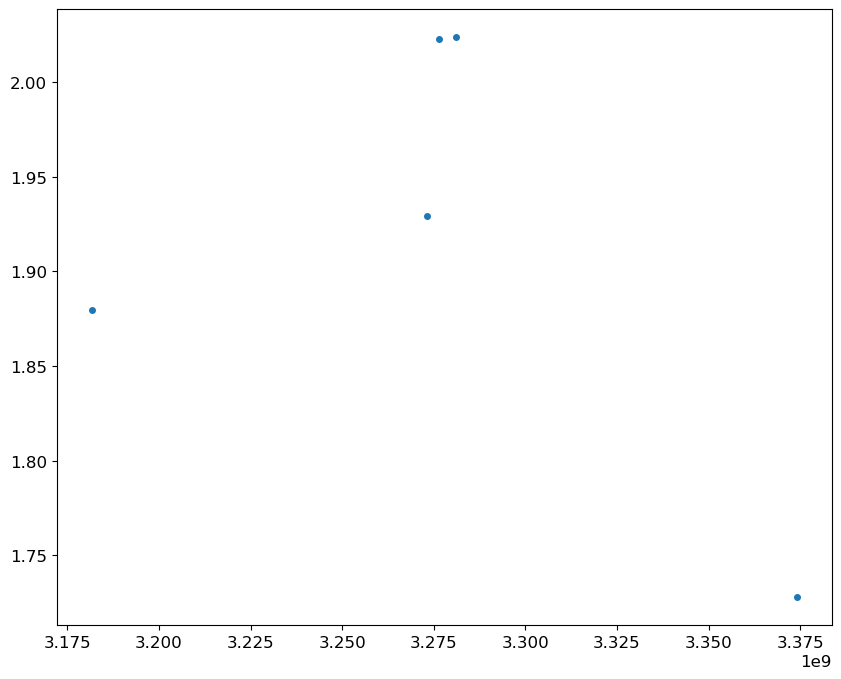

In [121]:
plt.figure
plot_full = False
if plot_full:
    plt.plot(freq_mean, qc_mean, 'o', markersize=4, label='DCM')
    plt.plot(freq_mean, qc_mean2, 'o', markersize=4, label='AO')
else:
    plt.plot(freq_mean, qc_mean2/qc_mean, 'o', markersize=4, label='AO')